# Full-Field Sampling vs Power Spectrum Inference

This notebook compares two approaches to cosmological parameter inference:
1. Full-field inference from convergence maps
2. Power spectrum (2PCF) inference from angular power spectra

We use full-sky configuration (observer at center) to enable anafast power spectrum computation.

## Imports

In [1]:
import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"
os.environ["EQX_ON_ERROR"] = "nan"
os.environ["JAX_ENABLE_X64"] = "False"
os.environ["JAX_PLATFORMS"] = "cpu"

import jax

jax.config.update("jax_enable_x64", False)

import time
from pathlib import Path

import healpy as hp
import jax.numpy as jnp
import jax_cosmo as jc
import matplotlib.pyplot as plt
import numpy as np
import numpyro.distributions as dist
from diffrax import RecursiveCheckpointAdjoint
from jaxpm.distributed import normal_field
from numpyro.handlers import condition, seed, trace
from scipy.stats import norm

from fwd_model_tools import Configurations, Planck18, full_field_probmodel, reconstruct_full_kappa
from fwd_model_tools.lensing_model import compute_box_size_from_redshift
from fwd_model_tools.plotting import plot_kappa, plot_lightcone, plot_posterior
from fwd_model_tools.powerspec_model import powerspec_probmodel , compute_cl_from_convergence_map
from fwd_model_tools.sampling import batched_sampling, load_samples

print(f"JAX devices: {jax.device_count()}")
print(f"JAX backend: {jax.default_backend()}")

/home/wassim/micromamba/envs/ffi12/lib/python3.12/site-packages/jax_cosmo/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


JAX devices: 1
JAX backend: cpu


## Configuration Parameters

In [2]:
output_dir = "output_03_comparison"
box_shape = (16 , 16 , 16)
max_redshift = 0.5
number_of_shells = 8
geometry = "spherical"
observer_position = (0.5, 0.5, 0.5)
num_warmup = 20
num_samples = 10
batch_count = 2
sampler = "MCLMC"
backend = "blackjax"
sigma_e = 0.3
magick_seed = 42

output_dir_path = Path(output_dir)
plots_dir = output_dir_path / "plots"
samples_dir_ff = output_dir_path / "samples_fullfield"
samples_dir_ps = output_dir_path / "samples_powerspec"
data_dir = output_dir_path / "data"

plots_dir.mkdir(parents=True, exist_ok=True)
samples_dir_ff.mkdir(parents=True, exist_ok=True)
samples_dir_ps.mkdir(parents=True, exist_ok=True)
data_dir.mkdir(parents=True, exist_ok=True)

fiducial_cosmology = Planck18()
box_size = compute_box_size_from_redshift(fiducial_cosmology, max_redshift, observer_position)

print(f"Box size: {box_size} Mpc/h")
print(f"Max redshift: {max_redshift}")
print(f"Observer position (full-sky): {observer_position}")

Box size: (2635.3309394477, 2635.3309394477, 2635.3309394477) Mpc/h
Max redshift: 0.5
Observer position (full-sky): (0.5, 0.5, 0.5)


## Setup Sharding and Redshift Distribution

In [3]:
if jax.device_count() > 1:
    from jax.sharding import NamedSharding
    from jax.sharding import PartitionSpec as P

    mesh = jax.make_mesh((4, 2), ("x", "y"))
    sharding = NamedSharding(mesh, P("x", "y"))
    print(f"Using sharding with mesh: (4, 2)")
else:
    sharding = None
    print("Single device mode - no sharding")

z = jnp.linspace(0, max_redshift, 1000)
z_centers = jnp.linspace(0.2, max_redshift - 0.01, 4)
z_centers = jnp.round(z_centers, 3)
print(f"z_centers = {z_centers}")

nz_shear = [
    jc.redshift.kde_nz(
        z,
        norm.pdf(z, loc=z_center, scale=0.12),
        bw=0.01,
        zmax=max_redshift,
        gals_per_arcmin2=g,
    )
    for z_center, g in zip(z_centers, [7, 8.5, 7.5, 7])
]
nbins = len(nz_shear)
print(f"Number of redshift bins: {nbins}")

Single device mode - no sharding
z_centers = [0.2   0.297 0.393 0.49 ]
Number of redshift bins: 4


## Instantiate Full-Field Model

In [4]:
config = Configurations(
    field_size=9.6,
    field_npix=box_shape[0],
    box_shape=box_shape,
    box_size=box_size,
    number_of_shells=number_of_shells,
    density_plane_npix=box_shape[0],
    nside=box_shape[0],
    density_plane_smoothing=0.1,
    nz_shear=nz_shear,
    fiducial_cosmology=Planck18,
    sigma_e=sigma_e,
    priors={
        "Omega_c": dist.Uniform(0.20, 0.3),
        "sigma8": dist.Uniform(0.6, 1.0),
    },
    t0=0.1,
    dt0=0.1,
    t1=1.0,
    min_redshift=0.01,
    max_redshift=max_redshift,
    sharding=sharding,
    halo_size=0 if sharding is None else box_shape[0] // 8,
    adjoint=RecursiveCheckpointAdjoint(4),
    geometry=geometry,
    observer_position=observer_position,
    log_lightcone=True,
    log_ic=False,
)

print("Configuration created")

initial_conditions = normal_field(jax.random.key(magick_seed), config.box_shape, sharding=sharding)
print("Initial conditions generated")

Configuration created
Initial conditions generated


## Trace Model and Plot Lightcone

In [5]:
print("Generating synthetic observations")

full_field_basemodel = full_field_probmodel(config)

fiducial_model = condition(
    full_field_basemodel,
    {
        "Omega_c": fiducial_cosmology.Omega_c,
        "sigma8": fiducial_cosmology.sigma8,
        "initial_conditions": initial_conditions,
    },
)

print("Tracing fiducial model...")
start_time = time.time()
model_trace = trace(seed(fiducial_model, 0)).get_trace()
elapsed = time.time() - start_time
print(f"Fiducial model traced in {elapsed:.2f}s")

kappa_keys = [f"kappa_{i}" for i in range(nbins)]
true_kappas_visible = {key: model_trace[key]["value"] for key in kappa_keys}

true_kappas_full = reconstruct_full_kappa(true_kappas_visible, config.nside, config.observer_position)

np.savez(
    data_dir / "true_kappas.npz",
    **true_kappas_visible,
    Omega_c=fiducial_cosmology.Omega_c,
    sigma8=fiducial_cosmology.sigma8,
)

true_lightcone = np.asarray(model_trace["lightcone"]["value"])
np.save(data_dir / "true_lightcone.npy", true_lightcone)

print("Saved observations to disk")

Generating synthetic observations
Tracing fiducial model...


/home/wassim/micromamba/envs/ffi12/lib/python3.12/site-packages/jax/_src/ops/scatter.py:108: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion=standard. In future JAX releases this will result in an error.
  warnings.warn(


Fiducial model traced in 3.81s
Saved observations to disk


## Plot Lightcone

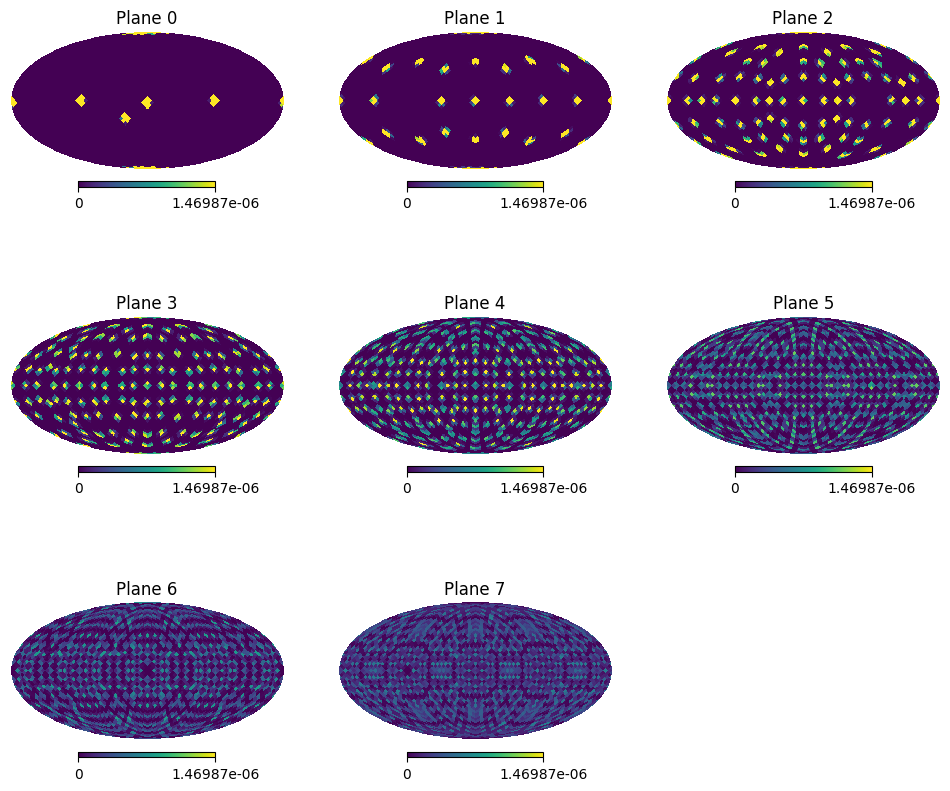

Plotted lightcone


In [6]:
plot_lightcone(true_lightcone, plots_dir, spherical=True, output_format="show")
print("Plotted lightcone")

## Plot Kappa Maps

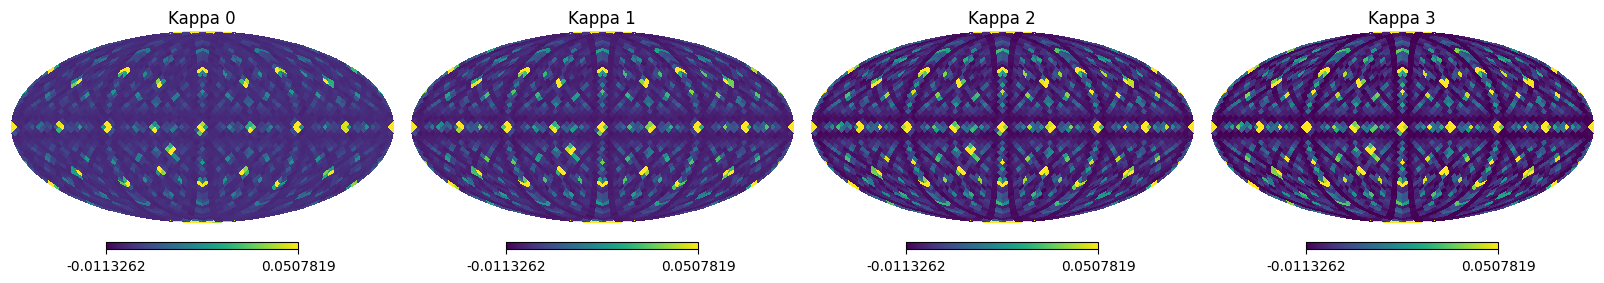

Plotted kappa maps


In [7]:
kappa_array = np.stack([true_kappas_full[k] for k in kappa_keys])
plot_kappa(kappa_array, plots_dir, spherical=True, output_format="show")
print("Plotted kappa maps")

## Compute Power Spectra using HEALPix anafast

For 4 redshift bins, we compute:
- 4 auto-spectra: C_ell^{ii}
- 6 cross-spectra: C_ell^{ij} for i < j
- Total: 10 power spectra

In [8]:
lmax = config.nside * 2 - 1
ell = jnp.arange(lmax + 1)[2:]
observed_cls = compute_cl_from_convergence_map(true_kappas_full, lmax)

print(f"got {len(observed_cls)} observed power spectra")
print(f"expected 10 power spectra: 4 auto-correlations and 6 cross-correlations")


got 10 observed power spectra
expected 10 power spectra: 4 auto-correlations and 6 cross-correlations


## Plot Power Spectra

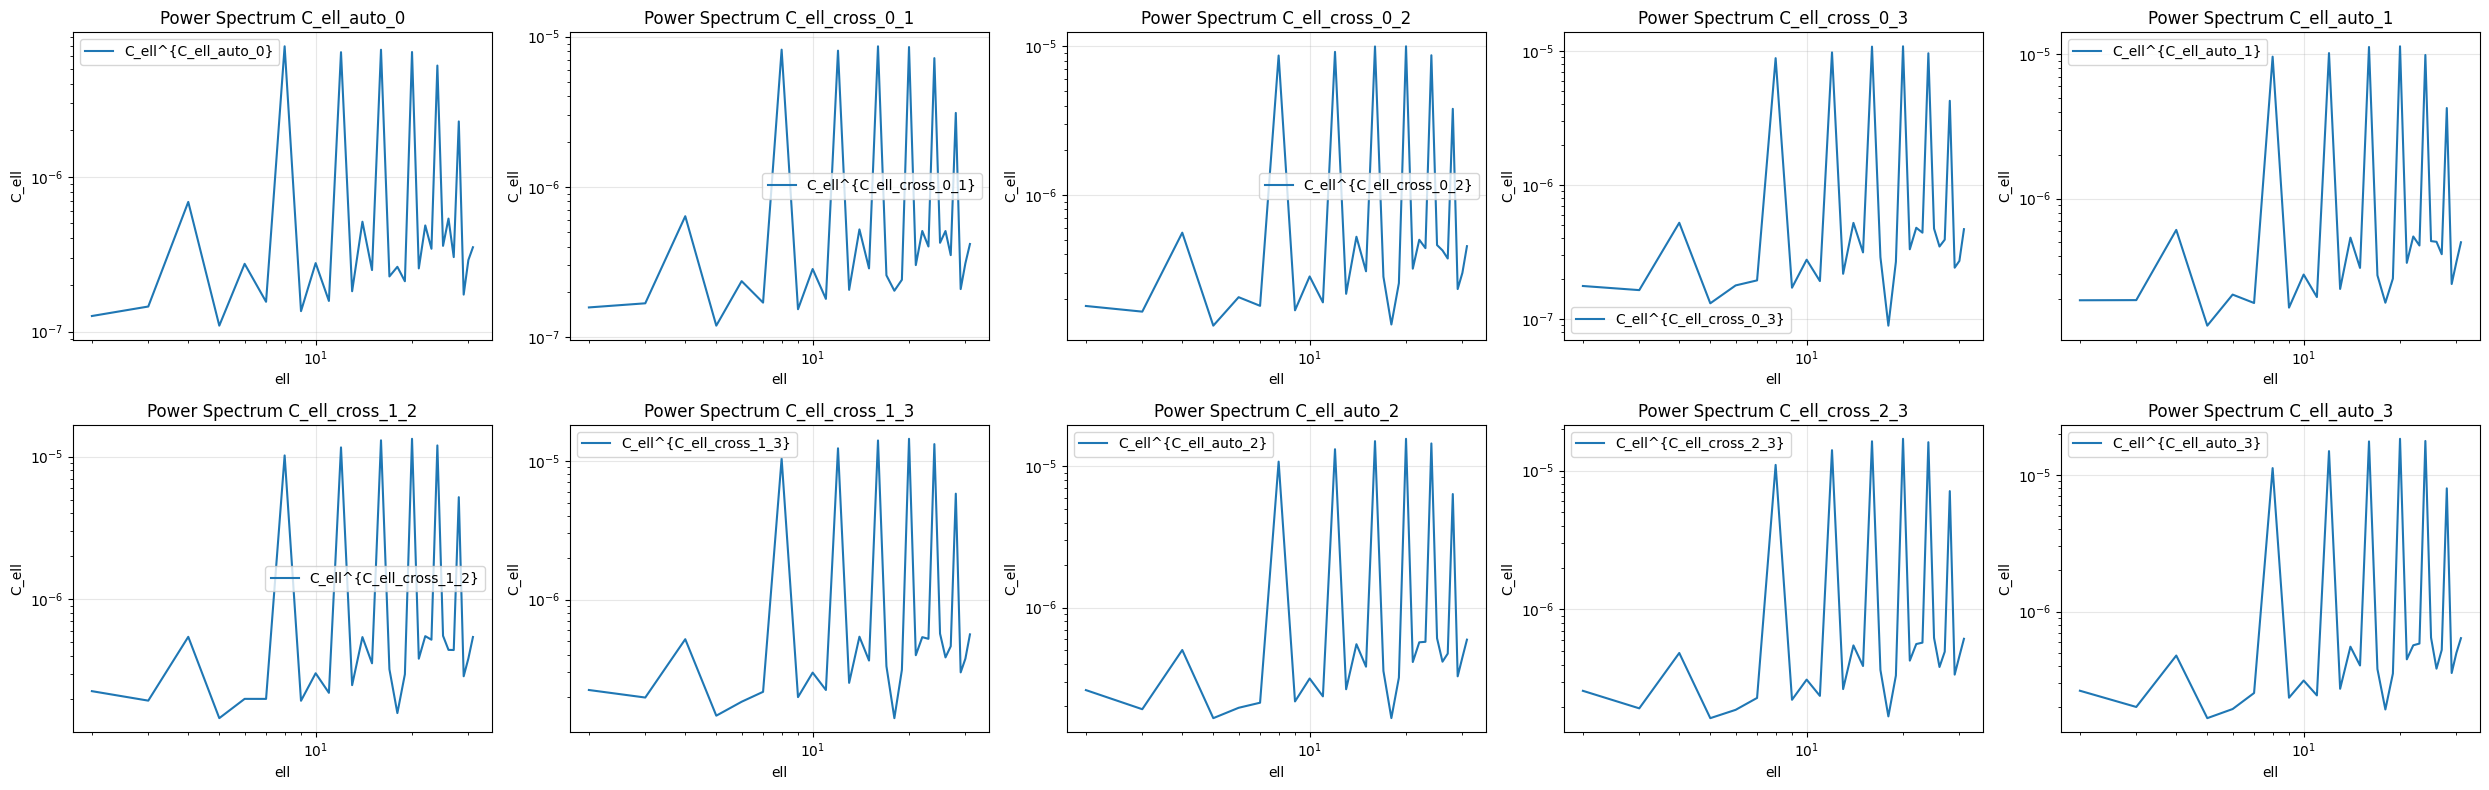

Plotted power spectra


In [9]:
fig, axes = plt.subplots(2, 5, figsize=(25, 8))
axes = axes.ravel()

for idx, name in enumerate(observed_cls.keys()):
    ax = axes[idx]
    cl = observed_cls[name]
    ax.loglog(ell, np.abs(cl), label=f"C_ell^{{{name}}}")
    ax.set_xlabel("ell")
    ax.set_ylabel("C_ell")
    ax.set_title(f"Power Spectrum {name}")
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()
print("Plotted power spectra")

## Full-Field Inference

### Condition on Kappa Maps

In [10]:
print("Setting up full-field MCMC inference")

config_inference = config._replace(log_lightcone=False, log_ic=False)
full_field_basemodel = full_field_probmodel(config_inference)

observed_model = condition(
    full_field_basemodel,
    {f"kappa_{i}": true_kappas_visible[f"kappa_{i}"] for i in range(nbins)},
)

init_params = {
    "Omega_c": fiducial_cosmology.Omega_c,
    "sigma8": fiducial_cosmology.sigma8,
    "initial_conditions": initial_conditions,
}
init_params = jax.tree.map(jnp.asarray, init_params)

print(f"Sampling with {sampler} using {backend} backend")

Setting up full-field MCMC inference
Sampling with MCLMC using blackjax backend


### Run Full-Field Sampling

In [11]:
batched_sampling(
    model=observed_model,
    path=str(samples_dir_ff),
    rng_key=jax.random.PRNGKey(magick_seed),
    num_warmup=num_warmup,
    num_samples=num_samples,
    batch_count=batch_count,
    sampler=sampler,
    backend=backend,
    save=True,
    init_params=init_params,
    progress_bar=True,
)

print("Full-field MCMC sampling completed")

üîÅ Starting fresh with warmup for MCLMC using blackjax...
üîß Tuning MCLMC parameters (L and step_size)...
üì¶ Sampling batch 1/2 using MCLMC with blackjax...

at sample batch 1, total samples: 0




üíæ Saving batch 1 samples and state...
üì¶ Sampling batch 2/2 using MCLMC with blackjax...

at sample batch 2, total samples: 10




üíæ Saving batch 2 samples and state...
Full-field MCMC sampling completed


### Load Full-Field Samples

In [11]:
samples_ff = load_samples(str(samples_dir_ff), param_names=["Omega_c", "sigma8"])
print(f"Loaded {len(samples_ff['Omega_c'])} full-field samples")

print("\nFull-Field Posterior Statistics:")
print(f"Omega_c: {samples_ff['Omega_c'].mean():.4f} ¬± {samples_ff['Omega_c'].std():.4f}")
print(f"sigma8: {samples_ff['sigma8'].mean():.4f} ¬± {samples_ff['sigma8'].std():.4f}")

Loading 2 sample batch(es) from output_03_comparison/samples_fullfield
  Loading batch 1/2: samples_0
  Loading batch 2/2: samples_1
Loaded 2 parameter(s): ['Omega_c', 'sigma8']
Total samples: 20
Loaded 20 full-field samples

Full-Field Posterior Statistics:
Omega_c: 0.2245 ¬± 0.0000
sigma8: 0.6108 ¬± 0.0000


/home/wassim/micromamba/envs/ffi12/lib/python3.12/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1345: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


## Power Spectrum Inference

### Instantiate Power Spectrum Model

In [12]:
print("Setting up power spectrum MCMC inference")

ell_jax = jnp.array(ell)
config = config._replace(ells=ell_jax)
powerspec_model = powerspec_probmodel(config)
observed_powerspec_model = condition(
    powerspec_model,
    observed_cls
)

init_params_ps = {
    "Omega_c": fiducial_cosmology.Omega_c,
    "sigma8": fiducial_cosmology.sigma8,
}
init_params_ps = jax.tree.map(jnp.asarray, init_params_ps)

print(f"Sampling with {sampler} using {backend} backend")

Setting up power spectrum MCMC inference
Sampling with MCLMC using blackjax backend


### Run Power Spectrum Sampling

In [13]:
batched_sampling(
    model=observed_powerspec_model,
    path=str(samples_dir_ps),
    rng_key=jax.random.PRNGKey(magick_seed + 1),
    num_warmup=num_warmup,
    num_samples=num_samples,
    batch_count=batch_count,
    sampler=sampler,
    backend=backend,
    save=True,
    init_params=init_params_ps,
    progress_bar=True,
)

print("Power spectrum MCMC sampling completed")

üîÅ Starting fresh with warmup for MCLMC using blackjax...
üîß Tuning MCLMC parameters (L and step_size)...


KeyboardInterrupt: 

### Load Power Spectrum Samples

In [ ]:
samples_ps = load_samples(str(samples_dir_ps), param_names=["Omega_c", "sigma8"])
print(f"Loaded {len(samples_ps['Omega_c'])} power spectrum samples")

print("\nPower Spectrum Posterior Statistics:")
print(f"Omega_c: {samples_ps['Omega_c'].mean():.4f} ¬± {samples_ps['Omega_c'].std():.4f}")
print(f"sigma8: {samples_ps['sigma8'].mean():.4f} ¬± {samples_ps['sigma8'].std():.4f}")

## Plot Both Posteriors on Same GetDist Plot

In [ ]:
from getdist import MCSamples
from getdist import plots as gdplots

true_data = np.load(data_dir / "true_kappas.npz")
true_Omega_c = float(true_data["Omega_c"])
true_sigma8 = float(true_data["sigma8"])

params = ("Omega_c", "sigma8")
labels = [r"\Omega_c", r"\sigma_8"]

samples_ff_array = np.column_stack([samples_ff[p] for p in params])
mc_samples_ff = MCSamples(samples=samples_ff_array, names=params, labels=labels, label="Full-Field")

samples_ps_array = np.column_stack([samples_ps[p] for p in params])
mc_samples_ps = MCSamples(samples=samples_ps_array, names=params, labels=labels, label="Power Spectrum")

markers_dict = {"Omega_c": true_Omega_c, "sigma8": true_sigma8}

gdplt = gdplots.get_subplot_plotter(width_inch=8)

gdplt.triangle_plot(
    [mc_samples_ff, mc_samples_ps],
    filled=True,
    contour_colors=["blue", "red"],
    markers=markers_dict,
    title_limit=1,
    legend_labels=["Full-Field", "Power Spectrum"],
)

plt.savefig(plots_dir / "comparison_posterior.png", dpi=600, bbox_inches="tight")
plt.show()
print("Plotted comparison posteriors")